In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'..')
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from food.paths import *
from stego.segment import get_food_segment
from segmentor.segment import *

dev
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/home/dima/FoodSeg103-Benchmark-v1/checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [3]:
port

5434

In [4]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [5]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [6]:
foods = pd.read_sql("""select f.*
                        from food.foods_prompted f""",engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()
food_clips = series2tensor(foods['clip'])

/home/dima/mytools/mytools/tools.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [7]:
url = 'https://image.shutterstock.com/z/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg'
img = get_image_from_url(url)
img = crop_image_to_square(img)
total_size = img.size[0]*img.size[1]

photo_id = url.split('/')[-1]

In [30]:
i = np.asarray(img, dtype="uint8")
i = np.flip(i,2)

segmentor_mask = inference_segmentor(segment_model, i)[0]

classes = np.unique(segmentor_mask)[1:]
classes_ =[]
urls = []
for c in classes:
    area = segmentor_mask[segmentor_mask==c].shape[0]
    if area> 100*100:
        class_mask = np.where(segmentor_mask==c,1,0)
        fname = f'{photo_id}_{c}.jpg'
        Image.fromarray(crop_zeros(img,class_mask)).save(fragment_reference_images_path/fname)
        urls.append(f'https://dima.grankin.eu/fragment_reference_images/{fname}')
        classes_.append(c)
classes = classes_

In [33]:
urls

['https://dima.grankin.eu/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg_28.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg_34.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg_37.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg_48.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg_66.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-qui

### inference with stego

In [34]:
stego_img,stego_mask = get_food_segment(img)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for d

In [35]:
stego_img.save(fragment_reference_images_path/f'{photo_id}_stego.jpg')
urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_stego.jpg')
    

In [49]:
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df=clip_df.reset_index(drop=True)
clip_df['classes'] = classes+[np.nan]
clip_df = clip_df[:-1][clip_df[:-1]['score']>0.24].append(clip_df.iloc[-1])

/tmp/ipykernel_3941304/2598237632.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3941304/2598237632.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3941304/2598237632.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3941304/2598237632.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_3941304/2598237632.py:3: FutureWarning: The frame.append method is deprec

In [52]:
clip_df['classes'].dropna().values

array([34., 66., 73., 81., 89.])

In [53]:
segmentor_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
urls = []
areas = []
classes = []
for c in clases: 
    area = mask[mask==c].shape[0]
    if area> 10*10:
        areas.append(area)
        urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_{c}.jpg')
        classes.append(c)
    

PosixPath('/home/dima/data/food/fragment_reference_images/stock-photo-healhty-vegan-lunch-bowl-avocado-quinoa-sweet-potato-tomato-spinach-and-chickpeas-vegetables-753381028.jpg_stego.jpg')

In [63]:
clip, df = search_clip(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_stego.jpg')

In [64]:
df

,id,description,category,energy,protein,carb,fat,text,clip,score
0,1102652,"Avocado, raw",Other vegetables and combinations,160.0,2.0,8.53,14.66,the food is other vegetables and combinations ...,"[0.038361773, 0.0035180408, 0.0042615873, -0.0...",0.234278


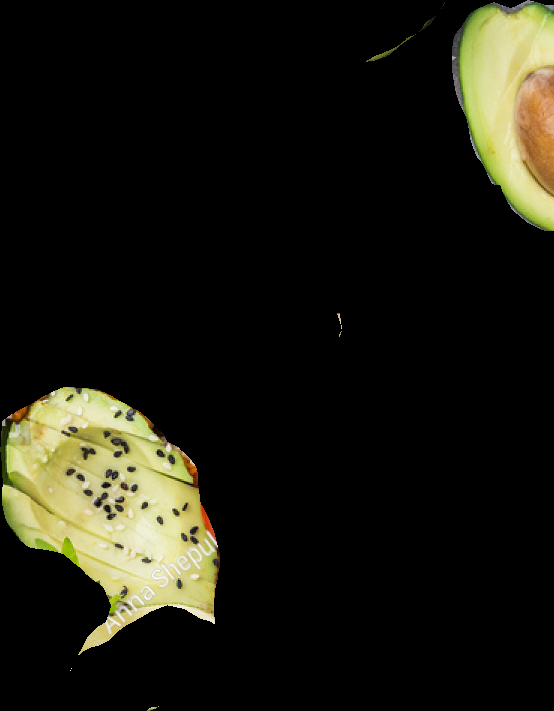

In [46]:
imgs[2]

In [51]:
np.array(food_mask)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

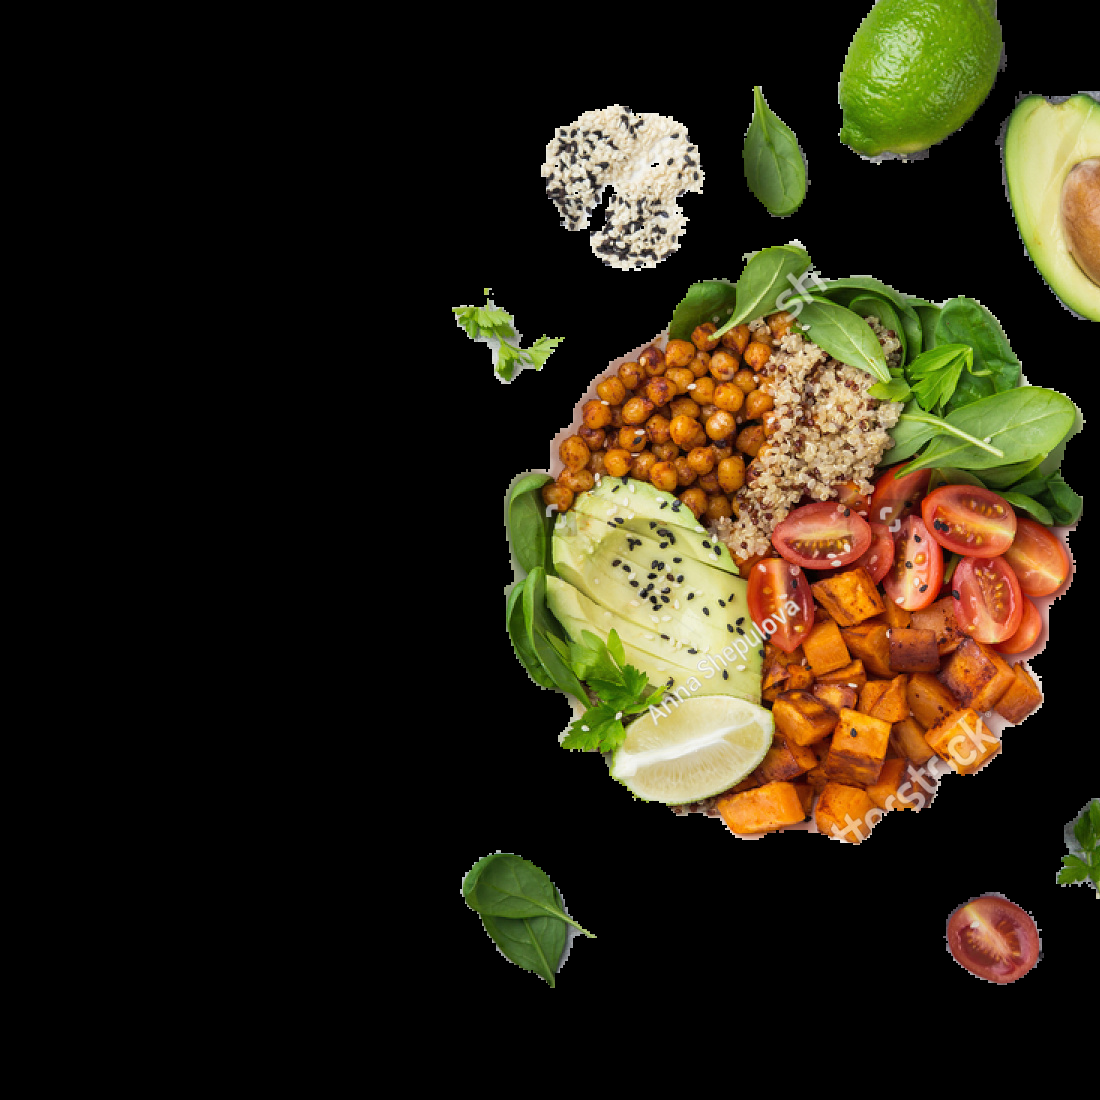

In [54]:
search_clip

/home/dima/FoodSeg103-Benchmark-v1/checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [101]:
import cv2

In [102]:
mask = save_segments(i,photo_id)

In [103]:
mask.shape

(1100, 1100)

In [104]:
np.unique(mask)

array([  0,  24,  28,  34,  37,  44,  48,  50,  52,  59,  66,  73,  80,
        81,  84,  89,  94, 103])

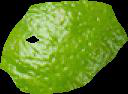

In [111]:
Image.open(fragment_reference_images_path.ls()[5])

In [16]:
#[p.unlink() for p in fragment_reference_images_path.ls()]

In [19]:
reference_images_path.ls()

[PosixPath('/home/dima/data/food/reference_images/AgACAgIAAxkBAAIv2GLMGSJwCHMH_gmFzWcydZGo2gNFAAIKvjEbdjRhSiro0tV-vosXAQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/reference_images/AgACAgIAAxkBAAIv2WLMGTUBeQK2yTmqvF1xXYpo4BTuAAIKvjEbdjRhSiro0tV-vosXAQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/reference_images/AgACAgIAAxkBAAIvy2LEVRNXjjCh6KGMVycz7vZjXeHsAAKyvDEbmPwhSubyGof7kWYQAQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/reference_images/AgACAgQAAxkBAAIvxWLB7q3q_M-23z3nGXd0X8k7tLk-AAJQuzEbAjsQUjBJSLdZoa0oAQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/reference_images/AgACAgIAAxkBAAIv12LMGHvo2q30yyOROZQwSRd2GJ7KAAIKvjEbdjRhSiro0tV-vosXAQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/reference_images/AgACAgIAAxkBAAIv2mLMGvewhH0jV3PsCFndiLxGJYZYAAIKvjEbdjRhSiro0tV-vosXAQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/reference_images/AgACAgIAAxkBAAIv3GLMG6SCyiLiJR-3YbEXFL7vpAUmAAIUvTEbH8dgSpPu31h8a7f7AQADAgADeQADKQQ'),
 PosixPath('/home/dima/data/food/referenc